<a href="https://colab.research.google.com/github/maxiperezc/memoscopio/blob/master/HPC/PerezCoto_Maximiliano_ejercicio_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cargas Electricas Libres en 2D


## 1 Introducción

El algoritmo siguiente consiste en la animacioón de un sistema de N cargas eléctricas de 1 Couloumb cada una, con N parametrizable como positivas y negativas, en el vacío, en 2 dimensiones y sus respectivos movimientos según la ley de atracción/repulsion que ejerce el resto de las cargas sobre cada una de las mismas.

La deducción del cáculo es la siguiente:

$ {\displaystyle {\vec {F}}=k_e{\frac {q_{2} \times q_{1}}{|r_{2}-r_{1}|^{2}}}{\hat {v_{r}}}\,} $

$ k_e={\frac {1}{4\pi \epsilon _{0}}} $ (cte no utilizada)

Si descomponemos en 2 dimensiones y como $q_n$ siempre es $1C$ o $-1C$:
 
---
$ F_x = {\frac {\pm {1}}{|r_{2x}-r_{1x}|^{2}}}{\cos \theta}$

$ {\cos \theta} = {\frac {adyacente}{hipotenusa}} = {\frac { {r_{2x}-r_{1x}} }{\sqrt {r_{2x}^{2}+r_{1x}^{2}}}} $

Reemplazando y simplificando:

$ F_x = {\frac {\pm {1}}{(r_{2x}-r_{1x}){\sqrt {r_{2x}^{2}+r_{1x}^{2}}} }} $

---

$ F_y = {\frac {\pm {1}}{|r_{2y}-r_{1y}|^{2}}}{\sin \theta}$

$ {\sin \theta} = {\frac {opuesto}{hipotenusa}} = {\frac { {r_{2y}-r_{1y}} }{\sqrt {r_{2y}^{2}+r_{1y}^{2}}}} $

Reemplazando y simplificando:

$ F_y = {\frac {\pm {1}}{(r_{2y}-r_{1y}){\sqrt {r_{2y}^{2}+r_{1y}^{2}}} }} $

---

Generalizando, las fuerzas en X e Y sobre una carga $q$ son las sumatorias de las fuerzas ejercidas por las demas cargas sobre esta carga $q$

$F_x(q_n) = {\sum_{k=1}^N F_x(q_n, q_k)}$

$F_y(q_n) = {\sum_{k=1}^N F_y(q_n, q_k)}$

---
Obtenida esta sumatoria de fuerzas para cada carga en dos vectores (arrays) Vx y Vy, procede a sumarsele el valor a cada eje en cada frame, obteniendo así movimiento no acelerado.


## 2 Armado del Ambiente

Deben especificarse los parametros de cantidad de cargas positivas, cantidad de cargas negativas y cantidad de frames que renderizará la animación resultante, mientras mas frames se pongan, mayor será la fluides pero se tardará mas en calcularse los valores para cada uno.

## 3 Desarrollo

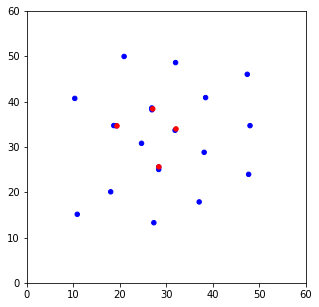

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML

anim = 0
positivas = 20#@param {type: "number"}
negativas = 4#@param {type: "number"}
frames    = 200#@param {type: "number"}
numcargas = positivas + negativas
colores = ['blue'] * positivas + ['red'] * negativas 

try:
  if positivas < 0:
    raise ValueError("Error: La cantidad de cargas positivas debe ser al menos 0.");
  if negativas < 0:
    raise ValueError("Error: La cantidad de cargas negativas debe ser al menos 0.");
  if frames < 1:
    raise ValueError("Error: La cantidad de frames debe ser al menos 1.");


  def move():
    x_cpu  = np.random.uniform(20.0, 40.0, size=numcargas)
    y_cpu  = np.random.uniform(20.0, 40.0, size=numcargas)
    carga  = [1] * positivas + [-1] * negativas 
    vx_cpu = [0.0] * numcargas
    vy_cpu = [0.0] * numcargas

    while True:
      for i in range( 0, numcargas ):
        vx_cpu[i] = 0
        vy_cpu[i] = 0
        ex = 0
        ey = 0

        for j in range( 0, numcargas ):
          if i != j:
            dx = x_cpu[j] - x_cpu[i]
            dy = y_cpu[j] - y_cpu[i]

            rsq = pow(dx,2) + pow(dy,2)
            rrt = rsq * np.sqrt(rsq)

            if rrt > 1:
              ch = carga[i]*carga[j]
              ex -= ch*dx/rrt
              ey -= ch*dy/rrt

        vx_cpu[i] += ex
        vy_cpu[i] += ey

      for i in range( 0, numcargas ):
        x_cpu[i] += vx_cpu[i]
        y_cpu[i] += vy_cpu[i]

      yield np.c_[x_cpu, y_cpu]

  def update(i):
      data = next(stream)
      scat.set_offsets(data)
      return scat,

  fig, ax = plt.subplots()
  fig.set_size_inches(5, 5)
  stream = move()
  x, y = next(stream).T
  scat = ax.scatter(x, y, c=colores, s=20, vmin=0, vmax=1)
  ax.axis([0, 60, 0, 60])
  anim = animation.FuncAnimation(fig, update, frames=np.arange(0, 1, 1/frames), interval=100, blit=True)
  rc('animation', html='jshtml')

except ValueError as VR:
  print(VR)

anim

## 4 OpenMP para el cálculo de posiciones
Consiste en el algoritmo interno del desarrollo anterior para calcular las posiciones de las cargas de forma secuencial sin OpenMP y paralela con OpenMP.



In [15]:
code = """
// Cargas Libres en el Vacio con OpenMP, usando c, ejecutado en Colab.

#include <iostream>
#include <vector>
#include <cstdlib>
#include <math.h>
#include <sys/time.h>
#include <omp.h>    // Cabecera OpenMP   

// ----------------------------------------------------------------------------
// Macros que miden el tiempo.

static double dHashTiempoHistory[3];
static struct timeval tv;

#define TIEMPO_INI( h )      \
   gettimeofday(&tv,NULL);   \
   dHashTiempoHistory[ h ] = tv.tv_sec + tv.tv_usec/1000000.0;
   
   
#define TIEMPO_FIN( h )      \
   gettimeofday(&tv,NULL);   \
   dHashTiempoHistory[ h ] = ((tv.tv_sec + tv.tv_usec/1000000.0) - dHashTiempoHistory[ h ]) * 1000; // Devuelvo en milisegundos
#define TIEMPO_GET( h ) dHashTiempoHistory[ h ]

#define HTH_TOTAL           1
#define HTH_CARGAS_SEC      2
#define HTH_CARGAS_OMP      3

// ----------------------------------------------------------------------------

int main(int argc, char* argv[]) 
{ 
  int i, j, f;
  int ch;
  double ex, ey, dx, dy;
  double rsq, rrt;
  int ci;
  float xp, yp;

  TIEMPO_INI( HTH_TOTAL )

  // Leo los parametros.
  if( argc != 4 )
  {
      std::cerr<< " Error en los parametros de indicar: (cargas positivas), (cargas negativas), (frames de renderizacion)."<<argc<<std::endl;
      exit( -1 );
  }

  int positivas = atoi( argv[1] );
  int negativas = atoi( argv[2] );
  int frames    = atoi( argv[3] );
  int numcargas = positivas + negativas;

  // --------------------------------------------
  // Defino la memoria de los vectores.

  std::vector<double> Xs( numcargas );
  std::vector<double> Ys( numcargas );
  std::vector<double> Xp( numcargas );
  std::vector<double> Yp( numcargas );
  std::vector<double> Vx( numcargas );
  std::vector<double> Vy( numcargas );
  std::vector<int>    C( numcargas );

  for (int i=0; i<numcargas; i++)
  {
    Xp[i] = Xs[i]  = (rand()/(double)RAND_MAX)*0.73;
    Yp[i] = Ys[i]  = (rand()/(double)RAND_MAX)*0.73;
    Vx[i] = 0;
    Vy[i] = 0;
    C[i]  = i < positivas ? 1 : -1;
  }

  // --------------------------------------------
  // Realizo la función CARGAS en forma secuencial.

  TIEMPO_INI( HTH_CARGAS_SEC )

  for(f=0; f<frames; f++)
  {
    for(i=0; i<numcargas; i++)
    {
      ex = 0;
      ey = 0;

      for(j=0; j<numcargas; j++)
      {
        if(i != j)
        {
          dx = Xs[j] - Xs[i];
          dy = Ys[j] - Ys[i];
          rsq = pow(dx, 2) + pow(dy, 2);
          rrt = rsq * sqrt(rsq);

          if(rrt > 1)
          {
            ch = C[i]*C[j];
            ex -= ch*dx/rrt;
            ey -= ch*dy/rrt;
          }
        }
      }

      Vx[i] += ex;
      Vy[i] += ey;
    }

    for(i=0; i<numcargas; i++){
      Xs[i] += Vx[i];
      Ys[i] += Vy[i];
    }
  }

  TIEMPO_FIN( HTH_CARGAS_SEC )

  // --------------------------------------------
  // Muestro los resultados en secuencial comparando solo el resultado final del primer punto
  std::cout<<"Secuencial:"<<std::endl;
  std::cout<<"(Xs, Ys): ("<<Xs[0]<<", "<<Ys[0]<<")"<<std::endl;

  // --------------------------------------------

  for (int i=0; i<numcargas; i++)
  {
    Vx[i] = 0;
    Vy[i] = 0;
  }
  
  // Realizo la función CARGAS con OpenMP.

  TIEMPO_INI( HTH_CARGAS_OMP )

  for(f=0; f<frames; f++)
  {
    
    for(i=0; i<numcargas; i++)
    {
      ex = 0;
      ey = 0;
      ci = C[i]; xp = Xp[i]; yp = Yp[i];

      for(j=0; j<numcargas; j++)
      {
        if(i != j)
        {
          dx = Xp[j] - xp;
          dy = Yp[j] - yp;
          rsq = pow(dx, 2) + pow(dy, 2);
          rrt = rsq * sqrt(rsq);

          if(rrt > 1)
          {
            ch = ci*C[j];
            ex -= ch*dx/rrt;
            ey -= ch*dy/rrt;
          }
        }
      }

      Vx[i] += ex;
      Vy[i] += ey;
    }

    #pragma omp parallel for
    for(i=0; i<numcargas; i++){
      Xp[i] += Vx[i];
      Yp[i] += Vy[i];
    }
  }

  TIEMPO_FIN( HTH_CARGAS_OMP )

  // --------------------------------------------
  // Muestro los resultados en paralelo comparando solo el resultado final del primer punto
  std::cout<<"Paralelo:"<<std::endl;
  std::cout<<"(Xp, Yp): ("<<Xp[0]<<", "<<Yp[0]<<")"<<std::endl;


  TIEMPO_FIN( HTH_TOTAL )

 std::cout<<"Valores Reales  :" <<std::endl;
 std::cout<<"Tiempo TOTAL     : "<<TIEMPO_GET(HTH_TOTAL   )<<" [ms]"<<std::endl;
 std::cout<<"Tiempo cargas Sec  : "<<TIEMPO_GET(HTH_CARGAS_SEC)<<" [ms]"<<std::endl;
 std::cout<<"Tiempo cargas Omp  : "<<TIEMPO_GET(HTH_CARGAS_OMP)<<" [ms]"<<std::endl;
 std::cout<<std::endl;
 std::cout<<"SpeedUp          : (tiempo Secuencial/tiempo paralelo) : "<<TIEMPO_GET(HTH_CARGAS_SEC)<<" / "<<TIEMPO_GET(HTH_CARGAS_OMP)<<" = "<<TIEMPO_GET(HTH_CARGAS_SEC)/TIEMPO_GET(HTH_CARGAS_OMP)<<std::endl;
 std::cout<<"Eficiencia       : SpeedUp/nro procesadores            : "<<TIEMPO_GET(HTH_CARGAS_SEC)/TIEMPO_GET(HTH_CARGAS_OMP)<<" / "<<omp_get_num_procs()<<" = "<<TIEMPO_GET(HTH_CARGAS_SEC)/(omp_get_num_procs()*TIEMPO_GET(HTH_CARGAS_OMP))<<std::endl;
 std::cout<<"Coste Sec        : nro procesadores*Tiempo             : "<<1<<" * "<<TIEMPO_GET(HTH_CARGAS_SEC)<<" = "<<TIEMPO_GET(HTH_CARGAS_SEC)<<std::endl;
 std::cout<<"Coste Omp        : nro procesadores*Tiempo             : "<<omp_get_num_procs()<<" * "<<TIEMPO_GET(HTH_CARGAS_OMP)<<" = "<<omp_get_num_procs()*TIEMPO_GET(HTH_CARGAS_OMP)<<std::endl;
 std::cout<<"Funcion Overhead : Coste Omp - tiempo Secuencial       : "<<omp_get_num_procs()*TIEMPO_GET(HTH_CARGAS_OMP)<<" - "<<TIEMPO_GET(HTH_CARGAS_SEC)<<" = "<<(omp_get_num_procs()*TIEMPO_GET(HTH_CARGAS_OMP))-TIEMPO_GET(HTH_CARGAS_SEC)<<std::endl;


 std::cout<<std::endl;
 std::cout<<"Valores Ideal: "<<std::endl;
 TIEMPO_GET(HTH_CARGAS_OMP) = TIEMPO_GET(HTH_CARGAS_SEC) / 2;
 std::cout<<"Tiempo CARGAS Sec  : "<<TIEMPO_GET(HTH_CARGAS_SEC)<<" [ms]"<<std::endl;
 std::cout<<"Tiempo CARGAS Omp  : "<<TIEMPO_GET(HTH_CARGAS_OMP)<<" [ms]"<<std::endl;

 std::cout<<"SpeedUp          : (tiempo Secuencial/tiempo paralelo) : "<<TIEMPO_GET(HTH_CARGAS_SEC)<<" / "<<TIEMPO_GET(HTH_CARGAS_OMP)<<" = "<<TIEMPO_GET(HTH_CARGAS_SEC)/TIEMPO_GET(HTH_CARGAS_OMP)<<std::endl;
 std::cout<<"Eficiencia       : SpeedUp/nro procesadores            : "<<TIEMPO_GET(HTH_CARGAS_SEC)/TIEMPO_GET(HTH_CARGAS_OMP)<<" / "<<omp_get_num_procs()<<" = "<<TIEMPO_GET(HTH_CARGAS_SEC)/(omp_get_num_procs()*TIEMPO_GET(HTH_CARGAS_OMP))<<std::endl;
 std::cout<<"Coste Sec        : nro procesadores*Tiempo             : "<<1<<" * "<<TIEMPO_GET(HTH_CARGAS_SEC)<<" = "<<TIEMPO_GET(HTH_CARGAS_SEC)<<std::endl;
 std::cout<<"Coste Omp        : nro procesadores*Tiempo             : "<<omp_get_num_procs()<<" * "<<TIEMPO_GET(HTH_CARGAS_OMP)<<" = "<<omp_get_num_procs()*TIEMPO_GET(HTH_CARGAS_OMP)<<std::endl;
 std::cout<<"Funcion Overhead : Coste Omp - tiempo Secuencial       : "<<omp_get_num_procs()*TIEMPO_GET(HTH_CARGAS_OMP)<<" - "<<TIEMPO_GET(HTH_CARGAS_SEC)<<" = "<<(omp_get_num_procs()*TIEMPO_GET(HTH_CARGAS_OMP))-TIEMPO_GET(HTH_CARGAS_SEC)<<std::endl;


}
// ----------------------------------------------------------------------------

"""
text_file = open("code_cargas.cpp", "w")
text_file.write(code)
text_file.close()

## 5. Compilación de código C

In [16]:
!g++ -o cargas -fopenmp code_cargas.cpp

## 6. Ejecución de Código

In [22]:
%env OMP_NUM_THREADS=4
!./cargas 1000 1000 200

env: OMP_NUM_THREADS=4
Secuencial:
(Xs, Ys): (17386.4, 12654.8)
Paralelo:
(Xp, Yp): (17385.4, 12651.3)
Valores Reales  :
Tiempo TOTAL     : 90312.4 [ms]
Tiempo cargas Sec  : 46552.8 [ms]
Tiempo cargas Omp  : 43759.3 [ms]

SpeedUp          : (tiempo Secuencial/tiempo paralelo) : 46552.8 / 43759.3 = 1.06384
Eficiencia       : SpeedUp/nro procesadores            : 1.06384 / 2 = 0.531919
Coste Sec        : nro procesadores*Tiempo             : 1 * 46552.8 = 46552.8
Coste Omp        : nro procesadores*Tiempo             : 2 * 43759.3 = 87518.5
Funcion Overhead : Coste Omp - tiempo Secuencial       : 87518.5 - 46552.8 = 40965.7

Valores Ideal: 
Tiempo CARGAS Sec  : 46552.8 [ms]
Tiempo CARGAS Omp  : 23276.4 [ms]
SpeedUp          : (tiempo Secuencial/tiempo paralelo) : 46552.8 / 23276.4 = 2
Eficiencia       : SpeedUp/nro procesadores            : 2 / 2 = 1
Coste Sec        : nro procesadores*Tiempo             : 1 * 46552.8 = 46552.8
Coste Omp        : nro procesadores*Tiempo             : 2 *

---
## 8. Medidas de prestaciones en algoritmos paralelos
Las tecnicas de HPC buscan reducir los tiempos de ejecución. Dos algoritmos pueden ejecutar en el mismo tiempo, pero uno de ellos usa menos procesadores [6,7]. 

### SpeedUp
Referencia a la ganacia de velocidad que se consigue con un algoritmo paralelo, al resolver el mismo problema con respecto al algoritmo secuencial.

$ SpeedUp = {\frac {TiempoSecuencial}{TiempoParalelo}} $

### Eficiencia
La eficiencia normaliza el valor del SpeedUp, al dividirlo por la cantidad de procesadores que se utilizaron para alcanzar la ganacia en velocidad. Dando la idea de la porción de tiempo que los procesadores se dedican al trabajo útil.

$ Eficiencia = {\frac {SpeedUp}{NroProcesadores}} $

### Costo
El costo de un algoritmo paralelo representa el tiempo realizado por todo el sistema en la resoluciòn del problema.

$ Costo = {NroProcesadores}\times{TiempoAlgoritmo} $

### Función Overhead
Es la diferencia entre el Coste y el tiempo secuencial. Mientras mayor es la función overhead, peor es el comportamiento del algoritmo paralelo.

$ Eficiencia = {\frac {Costo}{TiempoSecuencial}} $

---
# 9 Tabla de pasos de ejecución del programa

 Procesador | Función | Detalle
------------|---------|----------
CPU      |  @param               | Lectura de la parametros: cargas positivas, negativas y cantidad de frames.
CPU      |  import                | Importa los módulos para funcionar
CPU      |  try-except            | Se valida que los parametros sean correctos.
CPU      |  move()                | Define el algoritmo de movimiento de cargas
CPU      |  update()              | Función que se llama en cada frame de la animación.
CPU      |  scatter() | Dibuja el gráfico
CPU      |  FuncAnimation() | Crea una animacion en base al grafico y su update()
-      |  OpenMP     | -
CPU   | argc != 4   | Validacion de los parámetros.
CPU   | std::vector    | Llenado de los vectores (Xs, Ys), (Xp, Yp), (Vx, Vy)
CPU   | TIEMPO_INI   | Guarda el tiempo inicial para la ejecucion en secuencial.
CPU   | for(for(for(...) for(...)))  | Algoritmo de movimiento de cargas y frames
CPU   | TIEMPO_FIN   | Guarda el tiempo final para la ejecucion en secuencial.
CPU   | TIEMPO_INI   | Guarda el tiempo inicial para la ejecucion en paralelo.
CPU   | for(for(for(...) #pragma for(...)))   | Defino el sector que se va a ejecutar en paralelo.
CPU   | TIEMPO_FIN   | Guarda el tiempo final para la ejecucion en paralelo.
CPU   | std::cout   | Impresion de los resultados obtenidos
CPU   | open()   | Abre el archivo donde se almacena el codigo C++
CPU   | write()   | Escribe el archivo con el código fuente

---
## 10. Conclusión

Como puede apreciarse, la complejidad computacional para el cálculo de nuevas posicioines para cargas puntuales es del orden de $O^2$.

Si a esto se le suma una ejecución por cada frame de renderización, se transforma en un algoritmo de complejidad $O^3$.

La paralelización de este algoritmo a nivel frames no puede realizarse ya que arrojaría resultados atemporales. Luego aplicando paralelismo y/o concurrencia con threads sobre el algorimo de cálculo discreto, se obtienen rendimientos con un speed up de entre 0.2 a 0.5, o sea que empeoran el proceso drásticamente.

Por este motivo, la paralelización se aplica solo en la sumatoria final de acceso a los vectores, que es lo que realmente puede paralizarse sin problemas de performance, obteniendose así un speed up máximo de hasta 1.1 solamente cuando se utilizan mas de 4000 particulas con 200 frames de renderización.
En los casos en los que el algoritmo ejecuta con menos carga, se nota un decremento en la performance. Por esto decimos que no todo lo que brilla es oro cuando se trata de paralelismo y concurrencia, y siempre depende del algoritmo en cuestión y de las posibilidades del hardware.

### Pasos mas relevantes

1. Definir el algoritmo de calculo de movimiento de cargas libres en el vacío.
2. Renderizar la animación que demuestra el algoritmo funcionando.
3. Definir cual es la zona que se va a ejecutar en paralelo en OpenMP.
4. Encontrar valores que justifiquen la ejecución en paralelo.

---
## 11. Bibliografía

[1] Markdown Syntax Colab: [PDF](https://github.com/wvaliente/SOA_HPC/blob/main/Documentos/markdown-cheatsheet-online.pdf)

[2] Introducción a Python: [Página Colab](https://github.com/wvaliente/SOA_HPC/blob/main/Documentos/Python_Basico.ipynb) 

[3] Ley de Coulomb: [Referencia](https://es.wikipedia.org/wiki/Ley_de_Coulomb)

[4] Tutorial Point Colab: [PDF](https://github.com/wvaliente/SOA_HPC/blob/main/Documentos/markdown-cheatsheet-online.pdf)

[5] Introducción a las arquitecturas paralelas: [PDF](http://so-unlam.com.ar/material-clase/HPC/Arquitecturas_de_computadores_avanzadas_(Modulo_1).pdf)

[6] Animaciones en Python con Matplotlib: [Referencia](https://tacosdedatos.com/animaciones-matplotlib)